# Problem Set 2 - Decision Trees, Model Selection, and Ensemble Methods
## CSCI 4622 - Spring 2022
***
**Name**: Yixiao Lei 
***

This assignment is due on Canvas by **11:59PM on February 23rd**.

Submit only this Jupyter notebook to Canvas with the name format `PS2_<yourname>.ipynb`. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to homework 1.
***

## Overview 

Your task for this homework is to build a decision tree classifier from scratch. Of course, we provide some initial classes
that you'll be editing. Since last two problems will use the scikit-learn's DecisionTreeClassifier, your solution
does not have to be efficient as long as it passes the sanity checks in a reasonable time (typically less than ~1min).

We will run a small comparison between our implementation and Scikit's in Problem 2 to make sure we didn't miss anything.

The third part will introduce k-fold cross validation to find out how deep is the best decision tree classifier. The last problem
requires a _weak learner_, so we'll use a decision tree that yields lower performance. But with _Ensemble Methods_, we will be able to improve the performance by aggregating predictions from multiple weak learners.
For the ensemble methods, we'll explore bagging, Random Forest, and boosting (AdaBoost).

Any Machine Learning interview will almost certainly have a question or two about decision trees and how they're trained.
So understanding the code and trying to implement everything on your own will be the best way to prepare for such interviews.

Also remember, if your code is correct then the sanity checks should pass without any major issue.
But if the sanity checks pass that does not necessarily imply your code is 100% correct.

Happy coding!

In [1]:
import numpy as np
import matplotlib.pylab as plt
import tests
import data
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

### Problem 1 - Decision Trees [40 points]
***
The goal of this problem is to implement the core elements of the Decision Tree classifier.
We do not expect a highly efficient implementation of the functions since the ensemble methods will
use the implementation from scikit-learn.

We'll be testing our implementation on the same dataset we used for Naive Bayes.

|Age|Salary|Colorado Resident| Has Siblings | College degree|
|:------:|:-----------:| :----------:| :----------:|--:|
| 37 | 44,000 | Yes | No  | Yes|
| 61 | 52,000 | Yes | No  | No |
| 23 | 44,000 | No  | No  | Yes|
| 39 | 38,000 | No  | Yes | Yes|
| 48 | 49,000 | No  | No  | Yes|
| 57 | 92,000 | No  | Yes | No |
| 38 | 41,000 | No  | Yes | Yes|
| 27 | 35,000 | Yes | No  | No |
| 23 | 26,000 | Yes | No  | No |
| 38 | 45,000 | No  | No  | No |
| 32 | 50,000 | No  | No  | Yes|
| 25 | 52,000 | Yes | No  | Yes|


In [2]:
features = np.array([
    [37, 44000, 1, 0],
    [61, 52000, 1, 0],
    [23, 44000, 0, 0],
    [39, 38000, 0, 1],
    [48, 49000, 0, 0],
    [57, 92000, 0, 1],
    [38, 41000, 0, 1],
    [27, 35000, 1, 0],
    [23, 26000, 1, 0],
    [38, 45000, 0, 0],
    [32, 50000, 0, 0],
    [25, 52000, 1, 0]
])
labels = np.array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1])

Each leaf node (terminal node) in a decision tree has a label value assigned to it. The same label will be assigned
to all samples that reach the leaf node.
- 1.1 [2 pts] What is the best accuracy for a baseline classifier that predicts one label for all rows on the dataset above?
which label should it predict?
- 1.2 [5 pts] Complete `compute_label` to return the label that should be assigned to the leaf node based on training labels in `y`. If more than one label are possible, choose the one with the lowest value (e.g, if both `0` and `1` are possible, choose `0`)

% Write-up for 1.1 <br>
%BEGIN

In this case, if our model is just randomly pick the people, or guess the label for simple data point it should predict 1 and the best accuracy should be 58.3%.

%END

In [3]:
from collections import Counter
class LeafNode:
    def __init__(self, y):
        """
        :param y: 1-d array containing labels, of shape (num_points,)
        """
        self.label = self.compute_label(y)

    def __eq__(self, other):
        return (type(self) == type(other)) and (self.label == other.label)

    @staticmethod
    def compute_label(y):
        """
        return the label that yields best performance if predicted of all instances in y
        :param y:  1-d array containing labels
        :return: single label, integer
        """
        node_label = None
        #Workspace 1.2
        #TODO: Return the label that should be assigned to the leaf node
        #In case of multiple possible labels, choose the one with the lowest value
        #Make no assumptions about the number of class labels
        #BEGIN 
        node_label=1
        counts=Counter(y)
        number=max(counts.values())
        common_labels=[key for key, val in counts.items() if val ==number]
        if len(common_labels)>1:
            node_label=min(common_labels)
        else:
            node_label=common_labels[0]
        return node_label

    def predict(self, x):
        """
        return the label for one obervation x
        :param x: one sample, of shape (num_features)
        :return: label, integer
        """
        return self.label

In [4]:
# Test cell, uncomment to run the tests
tests.test_leaf(LeafNode)

Question 1.2: [PASS]


##### The tree also contains _parent nodes_. They can either be parents of: leaf nodes, parent nodes, or a combination of the two.
Each parent node has a left and a right child. A parent node is used when we can reduce the impurity of the labels by splitting
the training instances based on a certain threshold.

First, we'll need to choose an impurity measure. For classification, there are two mainstream measures: _gini index_ and _entropy_. We'll be using the latter for our implementation.

\begin{align}
\text{Gini}(y) = 1 - \sum_{c}  (p_c)^2 \text{  and  Entropy}(y) = -\sum_{c}  p_c . \log p_c ,
\end{align}

where $p_c$ is the probability of occurrence (ratio)  of class $c$ among the labels in $y$

- 1.3 [5 pts] Complete the function `entropy` that returns the entropy measure of labels in `y`.

_Hint: for the log function, use `np.log` and the convention `0 * log(0) = 0`. Make sure you handle multi-class labels (not just binary)._

In [5]:
def entropy(y):
    """
    :param y: 1-d array contains labels, of shape (num_points,)
    :return: float, entropy measure of the labels
    """
    entropy_value = 0
    # Workspace 1.3
    #TODO: Compute the entropy of the labels
    #BEGIN 
    class_number=np.unique(y)
    for i in class_number:
        p=len(y[y==i])/len(y)
        entropy_value += -p*np.log(p)
    #END
    return entropy_value

In [6]:
# Test cell, uncomment to run the tests
tests.test_entropy(entropy)

Question 1.3: [PASS]


Now that we're at a parent node, we decide to partition our label instances in $S$ to two parts indexed by $P_1$ and $P_2$,
and we want to compute how much this split reduces the impurity.

Using the impurity measure $\mathcal{M}$, this impurity reduction is computed as follows:
\begin{align}
\text{Reduction}(S, {P_1, P_2}) = \mathcal{M}(S) - \big[
    \frac{|P_1|}{|S|} .\mathcal{M}(S[P_1]) + \frac{|P_2|}{|S|}.\mathcal{M}(S[P_2])
    \big],
\end{align}

where $|A|$ denotes the size of the set $A$.

The main questions will be based on the entropy measure, in which case the `Reduction` is also called _information gain_
(reducing the entropy implies that the partitioning decision variable and the labels have a higher mutual information).

-  1.4 [5 pts] Complete the `impurity_reduction` function to return the impurity reduction of the split using the provided measure.

In [7]:
def impurity_reduction(y, left_indices, right_indices, impurity_measure=entropy):
    """
    :param y: all labels
    :param left_indices: the indices of the elements of y that belong to the left child
    :param right_indices: the indices of the elements of y that belong to the right child
    :param impurity_measure: function that takes 1d-array of labels and returns the impurity measure, defaults to entropy
    :return: impurity reduction of the split
    """
    impurity_reduce = 0
    # Workspace 1.4
    #BEGIN 
    weight_left=len(left_indices)/len(y)
    weight_right=len(right_indices)/len(y)
    impurity_reduce=impurity_measure(y)-(weight_left*impurity_measure(y[left_indices]) + weight_right*impurity_measure(y[right_indices]))
    #END
    return impurity_reduce

In [8]:
# Test cell, uncomment to run the tests
tests.test_information_gain(impurity_reduction, entropy)

Question 1.4: [PASS]


We'll use `best_partition` to look up for the feature and threshold that yields the partition with the best impurity reduction.

For each feature:
 - Compute all possible thresholds (use `split_values`)
 - For each threshold:
    - Split to `(left_indices, right_indices)` based on the threshold
    - Compute the impurity reduction of the split

The function then returns the feature and the threshold that yield the best impurity reduction (and the reduction value)

 - 1.5 [7 pts] Complete `best_partition`.
 
 _Hint: `split_values` is provided as a helper function. It takes the feature column and returns
the set of thresholds_

In [9]:
def split_values(feature_values):
    """
    Helper function to return the split values. if feature consists of the values f1 < f2 < f3 then
    this returns [(f2 + f1)/2, (f3 + f2)/2]
    :param feature_values: 1-d array of shape (num_points)
    :return: array of shape (max(m-1, 1),) where m is the number of unique values in feature_values
    """
    unique_values = np.unique(feature_values)
    if unique_values.shape[0] == 1:
        return unique_values
    return (unique_values[1:] + unique_values[:-1]) / 2


def best_partition(X, y, impurity_measure=entropy):
    """
    :param X: features array, shape (num_samples, num_features)
    :param y: labels of instances in X, shape (num_samples)
    :param impurity_measure: function that takes 1d-array of labels and returns the impurity measure
    :return: Return the best value and its corresponding threshold by splitting based on the different features.
    """

    best_feature, best_threshold, best_reduction = 0, 0, -np.inf

    #Workspace 1.5
    #TODO: Complete the function as detailed in the question and return description
    #BEGIN 
    max_info_gain=-float("inf")
    for i in range(X.shape[1]) :
        feature_values = X[:, i]
        possible=split_values(feature_values)
        for threshold in possible:
            left_child = []
            right_child = []
            for j in range(len(X)):
                if X[j][i] < threshold:
                    left_child.append(j)
                else:
                    right_child.append(j)
            #print(left_child,right_child)
            if len(left_child)>0 and len(right_child)>0:
                IG=impurity_reduction(y, left_child, right_child, impurity_measure=entropy)
           
                if IG>max_info_gain:
                    max_info_gain=IG
                    best_feature=i
                    best_threshold=threshold
                    best_reduction=max_info_gain

                
    
    #END
    return best_feature, best_threshold, best_reduction

In [10]:
# Test cell, uncomment to run the tests
# If you chose to not use split_values, then this test will likely fail
tests.test_best_partition(best_partition, entropy)

Question 1.5: [PASS]


We provide the implementation of the parent node below. Note that the `left_child` will take instance for which
`feature_id` value is < `feature_threshold`. We should construct our decision tree as such.

In [11]:
class ParentNode:

    def __init__(self, feature_id, feature_threshold, left_child, right_child):
        """
        Initialize a parent node.
        :param feature_id: the feature index on which the splitting will be done
        :param feature_threshold: the feature threshold. Left child takes item with features[features_id] < threshold
        :param left_child: left child node
        :param right_child: right child node
        """
        self.feature_id = feature_id
        self.threshold = feature_threshold
        self.left_child = left_child
        self.right_child = right_child

    def predict(self, x):
        """
        Predict the label of row x. If we're a leaf node, return the value of the leaf. Otherwise, call predict
        of the left/right child (depending on x[feature_index).
        This will be called by DecisionTree.predict
        :param x: 1-d array of shape (num_features)
        :return: integer, the label for x
        """
        if x[self.feature_id] < self.threshold:
            label = self.left_child.predict(x)
        else:
            label = self.right_child.predict(x)
        return label

Now we tackle the core of a decision tree. The tree is built in a recursive way. The recursion in `DecisionTree.build` works as follows:
- Parameters: `min_samples_split`, `impurity_measure`
- Inputs: `features`, `labels`, `depth`
- Base case of the recursion, return a leaf node if either:
    - `depth` is 0
    - `labels` contains less than `min_samples_split` elements
    - There is no impurity reduction (reduction<=0 for all splits)
- Recursion (there is a split with impurity reduction > 0):
    - create the left and right child nodes with `depth - 1`
    - return the parent node

The left child node will contain instances for which the feature with index `best_feature` is strictly lower than
`best_threshold` of the partition. The right child takes the remaining instances.

- 1.6 [8 pts] Complete `build` method of `DecisionTree`
- 1.7 [2 pts] Complete the `score` method that returns the accuracy on the given data

In [12]:
class DecisionTree:

    def __init__(self, max_depth=-1, min_samples_split=2, impurity_measure=entropy):
        """
        Initialize the decision tree
        :param max_depth: maximum depth of the tree
        :param min_samples_split: minimum number of samples required for a split
        :param impurity_measure: impurity measure function to use for best_partition, default to entropy
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_measure = impurity_measure
        self.root = None
        self.num_features = None

    def build(self, X, y, depth):
        """
        Recursive method used to build the decision tree nodes
        :param X: data that are used to build the tree, of shape (num_samples, num_features)
        :param y: labels of the samples in features, of shape (num_samples)
        :param depth: depth of the tree to create
        :return: the root node of the tree
        """
       
       
        if depth == 0 or len(y) < self.min_samples_split:
            # we reached the maximum depth or we don't have more than the minimum number of samples in the leaf
            return LeafNode(y)
        else:
            # Get the feature, threshold and information_gain of the best split
            feature_id, threshold, gain = best_partition(X, y, self.impurity_measure)
            # gain = 0 occurs when the labels have the same distribution in the child nodes
            # which means that the entropy of the children is the same as the parent's
            if gain > 0:
                # Workspace 1.6
                # TODO: create the left and right child nodes with depth - 1, return the parent node
                #BEGIN 
               # print(X,y)
                #print(feature_id, threshold, gain)
                dataset_left = np.array([row for row in X if row[feature_id]<threshold])
                dataset_right = np.array([row for row in X if row[feature_id]>=threshold])
                left_child = []
                right_child = []
                for j in range(len(X)):
                    if X[j][feature_id] < threshold:
                        left_child.append(j)
                    else:
                        right_child.append(j)
                
                
                left_subtree = self.build(dataset_left,y[left_child], depth-1)
                right_subtree = self.build(dataset_right,y[right_child],depth-1)
              
                return ParentNode(feature_id,threshold,left_subtree, right_subtree )
               
                #END
            else:
                # We reach here if information_gain <= 0
                return LeafNode(y)


    def fit(self, X, y):
        """
        :param X: Training samples
        :param y: training labels
        :return: trained classifier
        """
        self.num_features = X.shape[1]
        self.root = self.build(X, y, self.max_depth)
        return self

    def predict(self, X):
        """
        Loops through rows of X and predicts the labels one row at a time
        """
        y_hat = np.zeros((X.shape[0],), int)
        for i in range(X.shape[0]):
            y_hat[i] = self.root.predict(X[i])
        return y_hat

    def score(self, X, y):
        """
        Return the mean accuracy on the given test data and labels.
        :param X: Test samples, shape (num_points, num_features)
        :param y: true labels for X, shape (num_points,)
        :return: mean accuracy
        """
        accuracy = 0
        # Workspace 1.7
        #BEGIN 
        # code here
      
        k=self.predict(X)
        
        for i in k:
            if y[i]==k[i]:
                accuracy+=1
        #END
        #print(accuracy,k,y)
        accuracy=accuracy/len(y)
        return accuracy

In [13]:
# Test cell, uncomment to run the tests
# If you chose to not use split_values, then this test will likely fail
tests.test_tree_build(DecisionTree, entropy)

Question 1.6: [PASS]


- 1.8 [2 pts] We want to compare our `DecisionTree(max_depth=3, min_samples_split=2` to our NaiveBayes.
What's the accuracy we achieve on the training data using the tree? ( we train and evaluate using `(features, labels)`)

In [14]:
# Workspace 1.8
#BEGIN 
classifier=DecisionTree(max_depth=3, min_samples_split=2).fit(features, labels)
classifier.score(features, labels)
#END

1.0

- 1.9 [2 pts] Using `min_samples_split=2`, what is the minimum depth so that our `DecisionTree` fits perfectly our
training data `(labels, features)`.

In [15]:
# Workspace 1.9
# To show that the minimum required depth is n, you can provide the accuracy for depth = (n-1) and depth = n
#BEGIN 
classifier=DecisionTree(max_depth=2, min_samples_split=2).fit(features, labels)
print("if min split == 2 accurate score equal to", classifier.score(features, labels))
classifier=DecisionTree(max_depth=3, min_samples_split=2).fit(features, labels)
print("if min split == 3 accurate score equal to", classifier.score(features, labels))
#END

if min split == 2 accurate score equal to 1.0
if min split == 3 accurate score equal to 1.0


We provide an example below to display the structure of a decision tree.
- 1.10 (2pts) Edit it to show the tree for the required minimum depth found in 1.8

In [16]:
#BEGIN 
# code here
tree = DecisionTree(max_depth=3, min_samples_split=2).fit(features, labels)
tests.print_tree(tree, ["age", "salary", "resident", "siblings"])
#END

                  ┌│label: 0
       ┌|salary  │┘
       │|36500.00│┐
       │          │       ┌│label: 1
       │          └|age  │┘
       │           |37.50│┐
       │                  └│label: 1
|age  │┘
|52.50│┐
       └│label: 0


### Problem 2: DecisionTree vs DecisionTreeClassifier [6 points]

We've just showed that our decision tree is better than the naive NaiveBayes! Let see how it compares to scikit's DecisionTreeClassifier.

First, we'll need a fancier dataset. We are going to predict house price levels using the decision trees.

We start by loading preprocessed data that we'll use. Since the original House Prices  [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
 is for regression, we have to transform `HousePrices.y_train` and `HousePrices.y_test` to discrete values reflecting price level.

|Price range| Label|
|:----------:|--:|
| $ P < $125000|0|
|125000$\leq P < $ 160000| 1 |
|160000$ \leq P < $ 200000| 2 |
|200000$ \leq P $ | 3 |

- 2.1 [3 pts] Start by transforming `y_train` and `y_test` of `house_prices` to discrete values using the provided ranges

In [17]:
house_prices = data.HousePrices()
#Workspace 2.1
#TODO: Discretize y_train and y_test
#BEGIN 
y_train=house_prices.y_train
y_test=house_prices.y_test
for i in range(len(y_train)):
    if y_train[i] < 125000:
        y_train[i] = 0
    elif y_train[i] >= 125000 and y_train[i] < 160000:
        y_train[i] = 1
    elif y_train[i] >= 160000 and y_train[i] < 200000:
        y_train[i] = 2
    else:
        y_train[i] = 3
        
for i in range(len(y_test)):
    if y_test[i] < 125000:
        y_test[i] = 0
    elif y_test[i] >= 125000 and y_test[i] < 160000:
        y_test[i] = 1
    elif y_test[i] >= 160000 and y_test[i] < 200000:
        y_test[i] = 2
    else:
        y_test[i] = 3
#END
print(np.unique(house_prices.y_train), house_prices.X_train.shape)
print(np.unique(house_prices.y_test), house_prices.X_test.shape)

[0 1 2 3] (1166, 79)
[0 1 2 3] (292, 79)


- 2.2 [3 pts] Compare our `DecisionTree` and scikit's `DecisionTreeClassifier` on the house prices dataset by reporting the accuracies on the test data.

 [scikit's `DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
uses Gini index by default and only splits based on random subset of features (set `max_features` to None to use all features),
so refer to the documentation to change the impurity measure to entropy.

Use `max_depth = 5, min_samples_split=2` for the comparison.

In [18]:
# Workspace 2.2
#BEGIN 
tree = DecisionTree(max_depth=5, min_samples_split=2).fit(house_prices.X_train, y_train)
print("score for the DecisionTree should be ", tree.score(house_prices.X_test, y_test))

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
tree2=DecisionTreeClassifier(max_depth=5, min_samples_split=2).fit(house_prices.X_train, y_train)
print("score for using  scikit's DecisionTreeClassifier is ", tree2.score(house_prices.X_test, y_test))

#END

score for the DecisionTree should be  0.7705479452054794
score for using  scikit's DecisionTreeClassifier is  0.6917808219178082


#### Bonus questions
We've implemented `DecisionTree` to handle different measures of impurity. We want now to compare our implementation
to the standard `DecisionTreeClassifier` using Gini index.
- **(Bonus)** 2.3  [2 pts] Complete `gini` function

In [38]:
def gini(y):
    """
    :param y: 1-d array contains labels, of shape (num_points,)
    :return: float, gini index the labels
    """
    gini_index = 0
    # Workspace 2.3
    #TODO: Compute the gini index of the labels in y
    #BEGIN 
    class_labels = np.unique(y)
    gini = 0
    for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
    gini_index= 1 - gini
    #END
    return gini_index

- **(Bonus)** 2.4 [2 pts] Perform the same comparison as in 2.2 with gini index but without setting `max_features` to `None`. How do you explain the result?

In [20]:
np.random.seed(2) # to fix the randomness in DecisionTreeClassifier
# Workspace 2.4.a
#BEGIN 
# code here
#END

##### Write-up for 2.4.b
%BEGIN

% YOUR ANSWER HERE

%END


### Problem 3 - Model Selection via Cross Validation [16 points]
***
In this problem, we will be working with scikit-learn `DecisionTreeClassifier`. We want to figure out the best `max_depth` for our dataset.

In the house prices dataset, we only have a training set and a test set. The question then is how do we perform the model selection seen in Problem Set 1?

One way to do so is via **the cross validation set approach** which basically means setting aside a portion of our training data to use as a validation set.
The goal is to use the validation set to find the best hyperparameters for our model (`max_depth` in the case of decision trees).

- 3.1 [3 points] complete the `cross_validate` function to train the classifier on the training set and return the accuracy on the validation set based on provided indices.

In [21]:
def cross_validate(classifier, X, y, train_indices, valid_indices):
    """
    Train classifier on training set and validate on the validation set
    :param classifier: the classifier to use
    :param X: all data of shape (num_samples, num_features)
    :param y: all labels of shape (num_samples)
    :param train_indices:  indices to be used for training the model
    :param valid_indices:  indices to be used for validating the model
    :return: he accuracy of the classifier on the validation set
    """
    valid_accuracy = 0
    #Workspace 3.1
    #TODO: train and validate the model based on provided indices
    #Hint: use score method of the classifier
    #BEGIN 
   
    classifier.fit(X[train_indices],y[train_indices])
    valid_accuracy=classifier.score(X[valid_indices],y[valid_indices])
    #END
    return valid_accuracy

- 3.2 [2 points] Report the validation accuracy using the validation set approach for scikit-learn `DecisionTreeClassifier` with `max_depth=3`
 when using the last 100 training points as a validation set and the rest as training set.

In [22]:
#Workspace 3.2
#TODO: Report the cross validation accuracy using the last 100 training points as validation set
#and the rest of the training points as training
#BEGIN 
k=house_prices.X_train.shape[0]-100
k=cross_validate(DecisionTreeClassifier(max_depth=3),house_prices.X_train, y_train,list(range(0, k)) ,list(range(k, house_prices.X_train.shape[0])))
print(k)
#END

0.76


The issue with the validation set approach is that we're reducing the size of our training data,
 and the lower number of samples implies higher uncertainty.

A work-around is to use *k-fold cross validation*.
We start by partitioning the training data into k different and equally size partitions.
Then for each of the k runs, we keep a different chunk for the validation while using the remaining k-1 for training.
We note the validation accuracy during each of the k runs.

After each of the k-folds has been used as a validation set, the average of the k recorded accuracies becomes the performance of our model.
The k-fold cross validation method gives us a better estimate on how well the model would perform on new unseen data
 (test set) while allowing it to train on a larger portion of the dataset.
- 3.3 [5 points] Complete `k_fold_cv`. Use the helper function `partition_to_k` that generates the partition of indices to k different chunks.

In [23]:
from sklearn.model_selection import KFold
def partition_to_k(permutation, k):
    """
    Partition permutation (shuffled indices) to k different chunks and generate the train/valid splits for the k-fold
    :param permutation: shuffles indices
    :param k: number of folds
    :return: iterable of different k partitions
    """
    size = int(np.ceil(len(permutation)/k))
    for i in range(0, len(permutation), size):
        # valid indices j for which i < o(i) < i + size
        valid_indices = np.where(np.logical_and(permutation>i, permutation<= i + size))[0]
        # train indices j for which o(j) <= j  or o(j) >= j + size
        train_indices = np.where(~np.logical_and(permutation>i, permutation<= i + size))[0]
        yield train_indices, valid_indices

def k_fold_cv(classifier, k, X, y):
    """
    This function performs k-fold cross validation
    :param classifier: a classifier to be used
    :param k: number of folds
    :param X: all training data of shape (num_samples, num_features)
    :param y: all labels of shape (num_samples)
    :return: the average accuracy of the classifier in k-runs
    """
    #shuffle data indices
    permutation = np.random.RandomState(seed=42).permutation(range(X.shape[0]))
    mean_accuracy = 0
    #Workspace 3.3
    #BEGIN 
    valid_accuracy=[]

    shuffle=partition_to_k(permutation, k)
    
  
    train=[]
    test=[]
    for train_index, test_index in shuffle:
        train.append(train_index)
        test.append(test_index)
    for i in range(k):
        valid_accuracy.append(cross_validate(classifier, X, y, train[i], test[i]))

    mean_accuracy=np.mean(valid_accuracy)
    return mean_accuracy

- 3.4 [4 points] What is the best `max_depth` (consider depths from 1 to 10) and best cross validation accuracy chosen from 5-fold cross validation?

In [24]:
np.random.seed(4)  # changing the seed might yield different results
best_depth, best_accuracy = -1, 0

#Workspace 3.4
#TODO: 
#BEGIN 
kbest=[]
for i in range(1,10):
    k=k_fold_cv(DecisionTreeClassifier(max_depth=i),5 ,house_prices.X_train, y_train)
    kbest.append(k)
    if k>best_accuracy:
        best_depth=i
    best_accuracy=max(kbest)
#END
print("Cross validation accuracy for chosen best max_depth %d: %f" % (best_depth, best_accuracy))

Cross validation accuracy for chosen best max_depth 7: 0.679760


- 3.5 [2 pts] report the accuracy of the model with the best `max_depth` on the test set.

In [25]:
test_accuracy = 0
#Workspace 3.5
#BEGIN 
test_accuracy=k_fold_cv(DecisionTreeClassifier(max_depth=best_depth),5 ,house_prices.X_test, y_test)
#END
print ("accuracy of the best model on the testing set", test_accuracy)


accuracy of the best model on the testing set 0.6052388289676425


Problem 4 - Decision Tree Ensembles: Bagging [38 pts] and BONUS Boosting [5 pts]
---
We've seen that a DecisionTreeClassifier with depth = 3 is far from being the best performing on our house prices data.

In this problem, we will introduce 3 ensemble methods to _boost_ the performance of this poor and underestimated weak learner.

Whenever we need to generate a new instance of our weak learner, we'll have to call `get_weak_leaner`.
You can see below that the weak learner achieves lower accuracy compared to the tree from the previous problem.

In [26]:
def get_weak_learner():
    """Return a new instance of out chosen weak learner"""
    return DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.1)

In [27]:
weak_clf = get_weak_learner().fit(house_prices.X_train, house_prices.y_train)
print("Accuracy on the training set:", weak_clf.score(house_prices.X_train,house_prices.y_train))
print("Accuracy on the test set:    ", weak_clf.score(house_prices.X_test,house_prices.y_test))

Accuracy on the training set: 0.6552315608919382
Accuracy on the test set:     0.6575342465753424


Start by completing the `EnsembleTest` class that we'll use to evaluate different ensemble methods.

- 4.1 [5 points] Complete the `ensemble_test` class to fit the model received as parameter and store the metrics and running time.

You can use the function `plot_metric` to show and compare different statistics of each model in a bar chart.



In [28]:
from time import time
from sklearn.metrics import precision_score
import pandas as pd

class EnsembleTest:
    """
        Test multiple model performance
    """

    def __init__(self, dataset):
        """
        initialize EnsembleTest
        :param data: dataset containing Training and Test sets
        """
        self.dataset = dataset
        self.execution_time = {} # dictionary with key: model name, value: time taken to fit and score the model
        self.metric = {} # dictionary with key: model name, value: accuracy
        self.scores = {}# dictionary with key: model name, value: weighted average precision
        self.score_name = 'Precision(weighted)'
        self.metric_name = 'Mean accuracy'

    def evaluate_model(self, model, name):
        """
        Fit the model using the training data and save the evaluations metrics on the test set
        :param model: classifier to evaluate
        :param name: name of model
        """
        start = time()
        #Workspace 4.1
        #TODO: Fit the model and get the predictions to compute the metric and the score
        #BEGIN 
    
        model.fit(self.dataset.X_train,self.dataset.y_train)
        predictions = model.predict(self.dataset.X_test)
        self.scores[name] = precision_score(self.dataset.y_test, predictions, average='micro')
        
        num = sum(predictions == self.dataset.y_test)
        self.metric[name] = num / len(predictions)
        
        #END
        self.execution_time[name] = time() - start

    def print_result(self):
        """
            print results for all models trained and tested.
        """
        models_cross = pd.DataFrame({
            'Model': list(self.metric.keys()),
            self.score_name: list(self.scores.values()),
            self.metric_name: list(self.metric.values()),
            'Execution time': list(self.execution_time.values())})
        print(models_cross.sort_values(by=self.score_name, ascending=False))

    def plot_metrics(self):
        """
        Plot bar chart, one for each statistic (metric, score, running time)
        """
        fig, axs = plt.subplots(1, 3)
        fig.set_figheight(6), fig.set_figwidth(18)
        p = 0
        for stats, name in zip([self.metric, self.scores, self.execution_time],
                               [self.metric_name, self.score_name, "Elapsed time"]):
            left = [i for i in range(len(stats))]
            height = [stats[key] for key in stats]
            tick_label = [key for key in stats]
            axs[p].set_title(name)
            axs[p].bar(left, height, tick_label=tick_label, width=0.5)
            p += 1
        plt.show()

- 4.2 [3 points] Test `EnsembleTest` using our weak learner returned by `get_weak_learner`

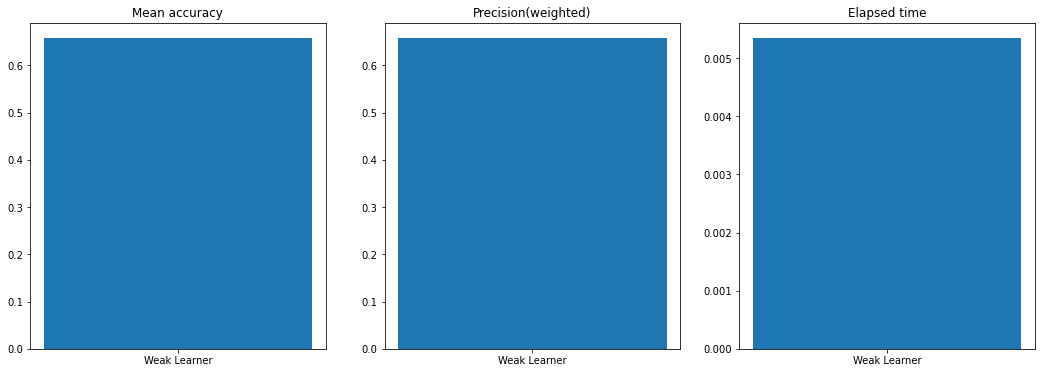

          Model  Precision(weighted)  Mean accuracy  Execution time
0  Weak Learner             0.657534       0.657534        0.005346


In [29]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = EnsembleTest(house_prices)
#Workspace 4.2
#TODO: Initialize weak learner and evaluate it using evaluate_model
#BEGIN 
weak_learner = get_weak_learner()
ensemble_handler.evaluate_model(weak_learner, "Weak Learner")
ensemble_handler.plot_metrics()
#END
ensemble_handler.print_result()

**Bagging:**

The first Ensemble technique we deal with is called _Bagging_ (Bootstrap AGGregatING).
Bagging consists of training a number of weak learners using randomly sampled instances from our data (with replacement). We have to start
by choosing the number of estimators we want to use. Then for each estimator, we sample a random subset of the data to fit the estimator.

To compute the prediction, we sum the prediction probabilities of the estimators and return the label that has the highest
accumulated probabilities.

- 4.3 [5 points] First, complete `sample_data` to return a random sample of size `sample_ratio* len(X_train)` of features and labels

- 4.4 [5 points] Complete `fit` by instantiating `n_estimators` of our weak leaner, each trained on random sample of the data

- 4.5 [5 points] Complete `predict` method to return the most likely label by combining different estimators predictions.
Instead of the majority vote used in KNNClassifier, you should use `predict_proba` method of DecisionTreeClassifier.
[See Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)

In [30]:
class BaggingEnsemble(object):

    def __init__(self, n_estimators, sample_ratio=1.0):
        """
        Initialize BaggingEnsemble
        :param n_estimators: number of estimators/weak learner to use
        :param sample_ratio: ratio of the training data to sample
        """
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.estimators = [] # List used in fit method to store the trained estimators

    def sample_data(self, X_train, y_train):
        X_sample, y_sample = None, None
        #Workspace 4.3
        #TODO: sample random subset of size sample_ratio * len(X_train), sampling is with replacement (iid)
        #BEGIN 
        total=len(X_train)
        pro = np.random.permutation(total)
        
        split = int(self.sample_ratio*total)
        
        X_sample= X_train[pro][:split]
        y_sample=y_train[pro][:split]
        #END
        return X_sample, y_sample

    def fit(self, X_train, y_train):
        """
        Train the different estimators on sampled data using provided training samples
        :param X_train: training samples, shape (num_samples, num_features)
        :param y_train: training labels, shape (num_samples)
        :return: self
        """
        np.random.seed(42) # Keep it to get consistent results across runs, you can change the seed value

        for _ in range(self.n_estimators):
            #BEGIN Workspace 3.6
            #TODO: sample data and create new weak learner trained on the sample
            
            weak_learner = get_weak_learner()
            x, y = self.sample_data(X_train, y_train)
            weak_learner.fit(x, y)
            self.estimators.append(weak_learner)
            
        return self
    def predict(self, X_test):
        """
        Predict the labels of test samples
        :param X_test: array of shape (num_points, num_features)
        :return: 1-d array of shape (num_points)
        """
        predicted_proba = 0
        answer = 0
        #Workspace 4.5
        #TODO: go through the trained estimators and accumulate their predicted_proba to get the mostly likely label
        #BEGIN 
        answer = np.zeros(len(X_test))
        accumulated_proba = np.zeros((len(X_test), 4))
        for estimator in self.estimators:
            proba = estimator.predict_proba(X_test)
            accumulated_proba += proba
            
            
        for i in range(len(accumulated_proba)):
            answer[i] = np.argmax(accumulated_proba[i])
        
        #END Workspace 3.7
       
        return answer



          Model  Precision(weighted)  Mean accuracy  Execution time
0  Weak Learner             0.657534       0.657534        0.005346
1       Bagging             0.657534       0.657534        0.040759


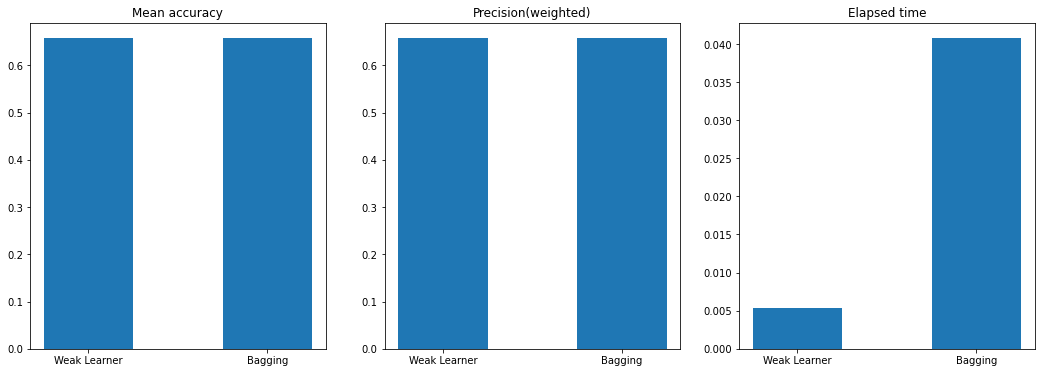

In [31]:
# This cell should run without errors
ensemble_handler.evaluate_model(BaggingEnsemble(10, 0.9), 'Bagging')
ensemble_handler.print_result()
ensemble_handler.plot_metrics()

**Random Forest**

Random Forest has an additional layer of randomness compared to Bagging: we also sample a random subset of the features (columns).
The rest of the implementation should be similar if not exactly the same as Bagging. In addition to keeping track of the estimators 
(in `RandomForest.estimators`, we also have to store the features indices that are used by each estimator (in `RandomForest.features_indices`).


- 4.6 [4 points] First, complete `sample_data` to return a random sample of size `sample_ratio* len(X_train)` of labels and `feature_ratio * num_features` of features

- 4.7 [4 points] Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on random sample of the data.
Make sure to keep track of the sampled features for each estimator to use them in the prediction step

- 4.8 [4 points] Complete `predict` method to return the most likely label by combining different estimators predictions. Instead of the majority vote used in KNNClassifier, you should use `predict_proba` method DecisionTreeClassifier:
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)


In [32]:
class RandomForest(object):

    def __init__(self, n_estimators, sample_ratio=1.0, features_ratio=1.0):
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.features_ratio = features_ratio
        self.estimators = [] # to store the estimator
        self.features_indices = [] # to store the feature indices used by each estimator

    def sample_data(self, X_train, y_train):
        X_sample, y_sample, features_indices = None, None, None
        #Workspace 4.6
        #TODO: sample random subset of size sample_ratio * len(X_train) and subset of features of size
        #         features_ratio * num_features
        #BEGIN 
        num_features = len(X_train[0])
        p = np.random.permutation(num_features)
        split_point = int(self.features_ratio*num_features)
        features_indices = np.arange(num_features)[p][:split_point]
        
        num_samples = len(X_train)
        p = np.random.permutation(num_samples)
        split_point = int(self.sample_ratio*num_samples)
        X_sample, y_sample = X_train[p][:split_point][:,features_indices], y_train[p][:split_point]
        
        #END
        return X_sample, y_sample, features_indices

    def fit(self, X_train, y_train):
        np.random.seed(42) # keep to have consistent results across run, you can change the value
        for _ in range(self.n_estimators):
            #Workspace 4.7
            #TODO: sample data with random subset of rows and features using sample_data
            #Hint: keep track of the features indices in features_indices to use in predict
            #BEGIN 
            weak_learner = get_weak_learner()
            x, y, features_indices = self.sample_data(X_train, y_train)
            self.features_indices.append(features_indices)
            weak_learner.fit(x, y)
            self.estimators.append(weak_learner)
            
            #END

    def predict(self, X_test):
        predicted_proba = 0
        answer = 0
        #Workspace 4.8
        #TODO: compute cumulative sum of predict proba from estimators and return the labels with highest likelihood
        #BEGIN 
        answer = np.zeros(len(X_test))
        accumulated_proba = np.zeros((len(X_test), 4))
        for i, estimator in enumerate(self.estimators):
            proba = estimator.predict_proba(X_test[:,self.features_indices[i]])
            accumulated_proba += proba
            
        for i in range(len(accumulated_proba)):
            answer[i] = np.argmax(accumulated_proba[i])
        #END
        return answer

In [33]:
# This cell should run without errors
ensemble_handler.evaluate_model(RandomForest(200, sample_ratio=0.7, features_ratio=0.1), 'RandomForest')
ensemble_handler.print_result()

          Model  Precision(weighted)  Mean accuracy  Execution time
0  Weak Learner             0.657534       0.657534        0.005346
1       Bagging             0.657534       0.657534        0.040759
2  RandomForest             0.616438       0.616438        0.106420


- 4.9 [3 points] Add different ensemble methods to the handler (try different parameters), plot, show, and compare them.
What's the best weighted average precision we can get? What's the best accuracy? Which ensemble method achieves each of them?
You can also compare to our best decision tree found in Problem 3.

          Model  Precision(weighted)  Mean accuracy  Execution time
1  RandomForest             0.715753       0.715753        0.463357
2       Bagging             0.708904       0.708904        0.345584
0  weak_learner             0.657534       0.657534        0.005356


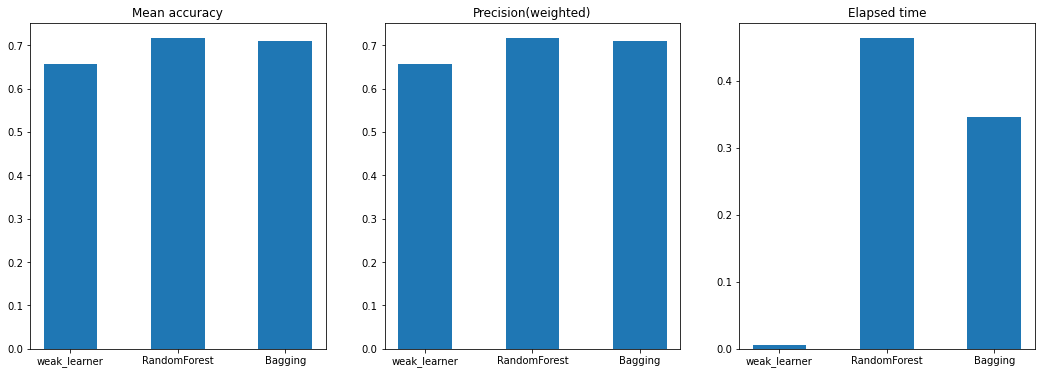

In [34]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = EnsembleTest(house_prices)
ensemble_handler.evaluate_model(get_weak_learner(), 'weak_learner')
#Workspace 4.9.a
#TODO Add multiple instances of the ensemble methods. Plot and compare their performance
#You can also add best tree from problem 3
#BEGIN 

ensemble_handler.evaluate_model(RandomForest(200, sample_ratio=0.7, features_ratio=0.8), 'RandomForest')
ensemble_handler.evaluate_model(BaggingEnsemble(200, 0.4),'Bagging')
ensemble_handler.print_result()
ensemble_handler.plot_metrics()
#END

#### Write-up 4.9.b
%BEGIN

The best weighted average precision should beRandomForest, the best accuracy is 0.7.

%END

**BONUS - Boosting**

There are different methods of boosting, but we'll focus in this problem on Adaptive Boosting (AdaBoost).
The logic of AdaBoost is to "push" each new learner to give more importance to previously misclassified data. We present
below the multiclass variant of AdaBoost [SAMME](https://web.stanford.edu/~hastie/Papers/samme.pdf). We denote $K$ the number of classes.

AdaBosst is performed by increasing the weights of misclassified samples after each iteration:
- Input: m samples $(X_i, y_i)_{i\in [m]}$, number of boosting rounds $N$
- Start with equal samples weights $W = (w_i), $ where   $w_i = \frac{1}{\texttt{n_samples}}$
- at round j:
    - Train estimator $h_j$ using current weights $W$
    - Get the predicted $(\hat{y}_i)$ on the training data using $h_j$
    - Find the weighted error rate $\epsilon_j$ using $W$: $\epsilon_j=\frac{\sum_i w_i \Delta(\hat{y}_i, y_i)}{\sum_i w_i}$
    - Choose $\alpha_j = \log \frac{1-\epsilon_j}{\epsilon_j} + \log(K-1)$
    - Update $W$ using: $w_i \leftarrow w_i \exp(\alpha_j \Delta(\hat{y_i}, y_i)) $
    - Normalize $W$ to have sum 1
- Global estimator is $H = \sum_j \alpha_j h_j$,

the $\Delta$ function equals to 1 when the two argument are different, 0 otherwise.

To understand how we implement $H$, imaging we have two classes, and we boosted for 3 rounds to get $(h_1, h_2, h_3)$,
with weights $(\alpha_1, \alpha_2, \alpha_3)$. When we want to predict the label of sample $x$, we get $(h_1(x), h_2(x), h_3(x)) = (0,1,0)$.

In this case, label $0$ gets a weight $\alpha_1+\alpha_2$, while class $1$ get weight $\alpha_2$. The predicted class is the one with
the largest weight (1 if $\alpha_2 > \alpha_1 + \alpha_3$, 0 otherwise)


- **(Bonus)** 4.10 [4 pts] Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on the same data but with different samples weights as detailed in the algorithm. Keep track of $(\alpha_i)$

_Hint: our weak learner (DecisionTreeClassifier) can take an argument `sample_weight` when calling the `fit` method, you'll have to use it to provide the weights $W$_
 

The `predict` method function is provided which returns the predicted label using the global estimator $H$. It uses one hot encoding of the predicted labels from the weak learners and cumulate the prediction with weights $\alpha_j$. 

Notice that if the estimator is consistent (0 error rate on the training set), AdaBoost $\alpha_j$ are no longer defined. That's why this method requires a **weak** learner.

In [35]:
class AdaBoost(object):

    def __init__(self, n_estimators):
        """
        :param n_estimators: number of estimators/ boosting rounds
        """
        self.n_estimators = n_estimators
        self.num_classes = None
        self.estimators = []
        self.alphas = []


    def fit(self, X_train, y_train):

        self.num_classes = np.unique(y_train).shape[0] # K in the algorithm
        weights = np.ones(len(X_train)) / len(X_train) # W in the algorithm
        # Workspace 4.10
        #TODO: Implement Multiclass Adaboost and keep track of the alpha_j
        #BEGIN 
        # code here
        #END

    def predict(self, X_test):
        '''
        get the labels returned by the global estimator defined as H
        the predicted label is the one that accumulates the largest sum of alphas
        '''
        # y_hat is one-hot encoding of the multi-class labels
        y_hat = np.zeros((X_test.shape[0], self.num_classes))
        for i in range(len(self.estimators)):
            # np.eye(k)[i] returns the one-hot encoding of size k for label i
            # np.eye(4)[2] would be [0, 0, 1, 0], np.eye(4)[0] is [1,0, 0, 0]. Clever, innit?
            y_hat += self.alphas[i] * np.eye(self.num_classes)[self.estimators[i].predict(X_test)]
        answer = np.argmax(y_hat, axis=1)
        return answer

In [36]:
ensemble_handler.evaluate_model(RandomForest(100, sample_ratio=0.8, features_ratio=0.8), 'RandomForest')
ensemble_handler.evaluate_model(AdaBoost(40), 'AdaBoost')
ensemble_handler.print_result()

          Model  Precision(weighted)  Mean accuracy  Execution time
1  RandomForest             0.712329       0.712329        0.267030
2       Bagging             0.708904       0.708904        0.345584
0  weak_learner             0.657534       0.657534        0.005356
3      AdaBoost             0.208904       0.208904        0.000935


# **Comparison**

- **(Bonus)**  4.11 [1 point] Run the same comparison as in 4.9 including AdaBoost.

In [37]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = EnsembleTest(house_prices)
ensemble_handler.evaluate_model(get_weak_learner(), 'weak_learner')
#Workspace 4.11.a
#TODO Add multiple instances of the ensemble methods. Plot and compare their performance
#You can also add best tree from problem 3
#BEGIN 
# code here
#END

#### Write-up 4.11.b
%BEGIN

% YOUR ANSWER HERE

%END